### Понадобится ли нам FAISS?

Хотя мы использовали индекс на уроке по работе с текстом, так ли он нужен в случае нашего датасета? Какой выигрыш по времени он дает?

Документация: https://faiss.ai/index.html

Пример: https://habr.com/ru/companies/okkamgroup/articles/509204/

10000 60000 110000 160000 210000 260000 310000 360000 410000 460000 
Результаты сравнения NumPy и FAISS (время и память):
 N (векторов)  NumPy поиск (с)  FAISS поиск (с)  Ускорение (поиск)  FAISS индекс (МБ)  FAISS создание (с)
        10000          0.01538          0.00089           17.34530           29.29692             0.01057
        60000          0.05191          0.00463           11.21645          175.78129             0.02769
       110000          0.10460          0.01124            9.30493          322.26567             0.04430
       160000          0.14748          0.01269           11.62223          468.75004             0.05981
       210000          0.23224          0.02663            8.71953          615.23442             0.09239
       260000          0.29769          0.02439           12.20505          761.71879             0.12818
       310000          0.35323          0.02734           12.91931          908.20317             0.16015
       360000          0.40504

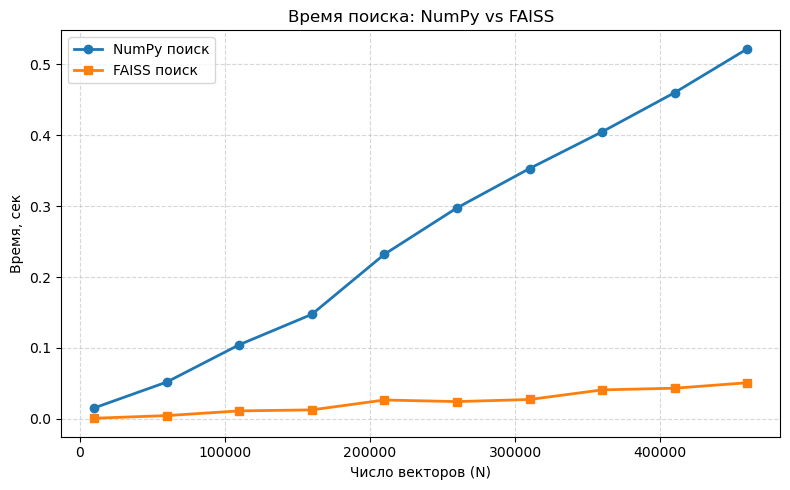

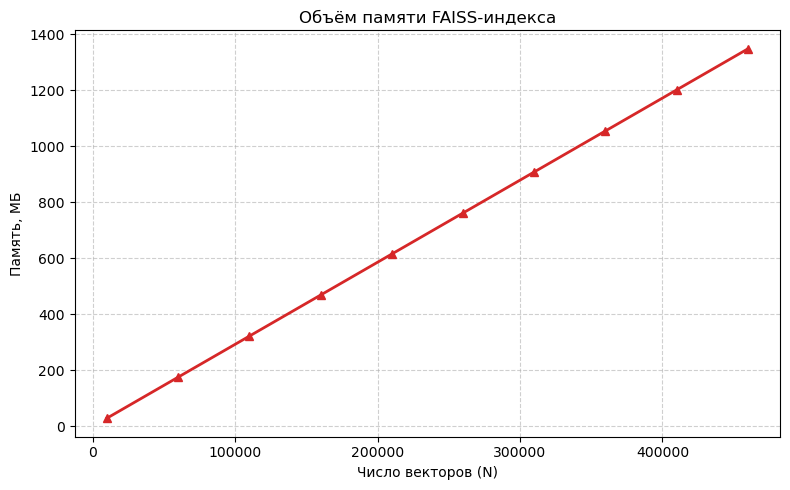

In [2]:
import numpy as np
import faiss
import time
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

d = 768  # размерность эмбеддингов
start, stop, step = 10_000, 500_000, 50_000
dataset_sizes = [n for n in range(start, stop + 1, step)]  # генератор списка
k = 5  # число ближайших соседей
n_runs = 3  # количество повторов для усреднения

results = []

for n in dataset_sizes:
    print(f'{n}', end=" ")
    times_numpy = []
    faiss_build_times = []
    faiss_search_times = []
    faiss_index_sizes = []  # байты

    for _ in range(n_runs):
        # --- Генерация данных ---
        embeddings = np.random.rand(n, d).astype('float32')
        query = np.random.rand(1, d).astype('float32')

        # --- NumPy (точный косинус) ---
        t0 = time.perf_counter()
        sims = cosine_similarity(query, embeddings)
        times_numpy.append(time.perf_counter() - t0)

        # --- FAISS (IndexFlatIP) ---
        # 1) создание индекса (+ нормализация под косинус)
        t0 = time.perf_counter()
        index = faiss.IndexFlatIP(d)
        faiss.normalize_L2(embeddings)
        index.add(embeddings)
        faiss_build_times.append(time.perf_counter() - t0)

        # замер занимаемой памяти индексом
        idx_bytes = len(faiss.serialize_index(index))
        faiss_index_sizes.append(idx_bytes)

        # 2) поиск
        faiss.normalize_L2(query)
        t0 = time.perf_counter()
        index.search(query, k)
        faiss_search_times.append(time.perf_counter() - t0)

    results.append({
        "N (векторов)": n,
        "NumPy поиск (с)": np.mean(times_numpy),
        "FAISS поиск (с)": np.mean(faiss_search_times),
        "Ускорение (поиск)": np.mean(times_numpy) / np.mean(faiss_search_times),
        "FAISS индекс (МБ)": np.mean(faiss_index_sizes) / (1024 ** 2),
        "FAISS создание (с)": np.mean(faiss_build_times),
    })

# Все результаты в виде таблицы
df = pd.DataFrame(results)
pd.set_option('display.float_format', lambda x: f"{x:,.5f}")
print("\nРезультаты сравнения NumPy и FAISS (время и память):")
print(df.to_string(index=False))
# Покажем время поиска
import matplotlib.pyplot as plt

# Покажем время поиска
plt.figure(figsize=(8, 5))
plt.plot(df["N (векторов)"], df["NumPy поиск (с)"], marker="o", linewidth=2, label="NumPy поиск")
plt.plot(df["N (векторов)"], df["FAISS поиск (с)"], marker="s", linewidth=2, label="FAISS поиск")

plt.title("Время поиска: NumPy vs FAISS")
plt.xlabel("Число векторов (N)")
plt.ylabel("Время, сек")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Покажем объем памяти, занимаемый индексом
plt.figure(figsize=(8, 5))
plt.plot(df["N (векторов)"], df["FAISS индекс (МБ)"], marker="^", color="tab:red", linewidth=2)
plt.title("Объём памяти FAISS-индекса")
plt.xlabel("Число векторов (N)")
plt.ylabel("Память, МБ")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Выводы

FAISS FlatIP дает огромное ускорение при поиске, но заплатить придется памятью. Возможно, затраты памяти на другие типы индексов растет меньшими темпами, нужно будет изучить.

А пока что не будем применять FAISS, так как при текущем размере датасета ~10к и даже при его росте до 100к разница в секундах не будет заметна.